In [1]:
import os
import mediapipe as mp 
import numpy as np
import cv2
import math
import pickle
import tensorflow as tf


# **1. Alphabet Landmarks**

---

In [2]:
list_of_metrics = {}

### Common Functions used:

In [3]:
def preprocess(data, labels):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split

    # STEP 1: Data Distribution Check
    print("Data Shape: ", data.shape, "||  Label Shape: ", labels.shape)
    unique, counts = np.unique(labels, return_counts=True)
    print("\nOriginal Label Distribution:\n", dict(zip(unique, counts)))

    # STEP 2: Convert labels to a Categorical Variable
    lab = tf.keras.utils.to_categorical(labels)

    # STEP 3: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(data, lab, test_size=0.2, random_state=42)

    unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
    print("\nTraining:\n", X_train.shape, y_train.shape, "\n") #, dict(zip(unique, counts)))

    unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
    print("Test:\n", X_test.shape, y_test.shape, "\n") #, dict(zip(unique, counts)))

    return X_train, X_test, y_train, y_test
        

In [4]:
def train_model(input_shape = (21,2), output_shape=24):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    if(input_shape[1]==0):
        model = Sequential([
            Flatten(input_shape=(input_shape[0],)),
            Dense(64,  activation='relu'),
            Dense(128, activation='relu'),
            Dense(512, activation='relu'),
            Dropout(rate=0.1),
            Dense(512, activation='relu'),
            Dropout(rate=0.2),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(output_shape, activation='softmax'),
        ])
    else:
        model = Sequential([
            Flatten(input_shape=(input_shape[0],input_shape[1])),
            Dense(64,  activation='relu'),
            Dense(128, activation='relu'),
            Dense(512, activation='relu'),
            Dropout(rate=0.1),
            Dense(512, activation='relu'),
            Dropout(rate=0.2),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(output_shape, activation='softmax'),
        ])

    # model.summary()

    callback_checkpoint = ModelCheckpoint(
        './checkpoints/', monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch',
    )
    callback_loss = EarlyStopping(monitor='loss', patience=4)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        callbacks=[callback_checkpoint, callback_loss])
    return model, history

In [5]:
def evaluate_model(history, X_test, y_test, model, title, actions):
  """
    Input: 
      history - Model history variable
      X_test - Test features
      y_test - Target test variables
      model - Keras Model 

    Output:
      Accuracy Plot (Training + Validation)
      Loss Plot (Training + Validation)
      Confusion matrix
      Accuracy
      Classification Report
  """  

  from sklearn.metrics import classification_report, confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  scores = model.evaluate((X_test),y_test, verbose=0)
  
  fig, axs = plt.subplots(1,3, figsize=(22,6))
  fig.tight_layout()

  axs[0].plot(history.history['accuracy'])
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Model - Accuracy (' + title +")")
  axs[0].legend(['Training'], loc='lower right')

  axs[1].plot(history.history['loss'])
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Model Loss')
  axs[1].set_title('Model - Loss (' + title +")")
  axs[1].legend(['Training'], loc='upper right')

  target_names=actions
  
  y_true=[]
  for element in y_test:
      y_true.append(np.argmax(element))

  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba,axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)    
  g = sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[2],
                  xticklabels=target_names, yticklabels=target_names)
  axs[2].set_title("Confusion Matrix")
  plt.show()


  print("\nAccuracy: %.2f%% \n" % (scores[1]*100))
  print(classification_report(y_true, prediction, target_names=target_names))

  return {"metrics": classification_report(y_true, prediction, target_names=target_names, output_dict=True)}

In [6]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [7]:
def get_distance(a,b):
    from math import pow, sqrt
    return round(sqrt(pow(b[0]-a[0],2) + pow(b[1]-a[1],2)), 4)

### Loading Landmarks and Labels

In [8]:
LANDMARK_PATH = os.path.join('./data/Character_Data_Landmarks')

actions = [chr(i) for i in range(ord('A'), ord('Z')) if chr(i)!='T']

no_sequences =  25
sequence_length = 30

print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [9]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


## **A. Neural Networks**

### **i) Just (X,Y)**

In [14]:
missing = []
data = []
labels = []

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                landmarks = []
                for handslms in result:
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        # landmarks.append([lmx, lmy])
                        landmarks.append(lmy)
                        landmarks.append(lmy)
                
                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [15]:
print(data.shape, labels.shape)

(17764, 42) (17764,)


In [16]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 42) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 42) (14211, 24) 

Test:
 (3553, 42) (3553, 24) 



In [17]:
model_xy, history = train_model( (X_train.shape[1],0), y_train.shape[1])
# model_xy, history = train_model( (X_train.shape[1], X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 4ms/step - loss: 2.5936 - accuracy: 0.3093
Epoch 2/50
445/445 [==============================] - 2s 4ms/step - loss: 0.6566 - accuracy: 0.7475
Epoch 3/50
445/445 [==============================] - 2s 3ms/step - loss: 0.4504 - accuracy: 0.8287
Epoch 4/50
445/445 [==============================] - 2s 3ms/step - loss: 0.4307 - accuracy: 0.8409
Epoch 5/50
445/445 [==============================] - 2s 3ms/step - loss: 0.4225 - accuracy: 0.8460
Epoch 6/50
445/445 [==============================] - 2s 3ms/step - loss: 0.3424 - accuracy: 0.8762
Epoch 7/50
445/445 [==============================] - 2s 3ms/step - loss: 0.3322 - accuracy: 0.8754
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3642 - accuracy: 0.8681
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3266 - accuracy: 0.8809
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3548 - accuracy: 0.8675

In [ ]:
model_xy.save("./model_saves/only_coordinates")

In [ ]:
from tensorflow.keras.models import load_model

model_xy = load_model("./model_saves/only_coordinates")

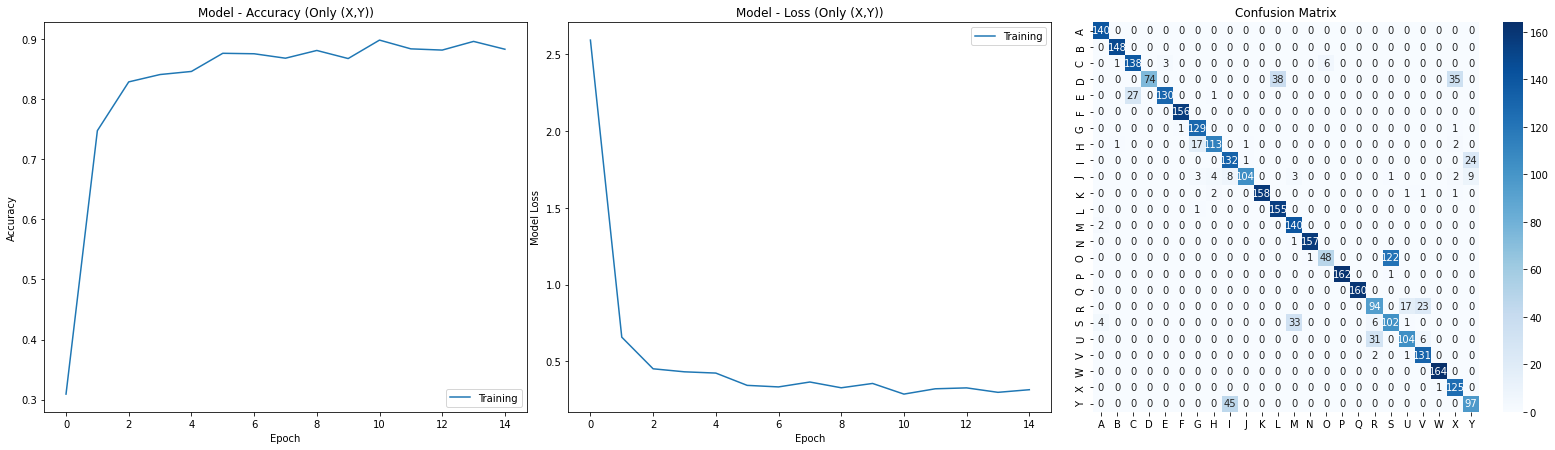


Accuracy: 86.15% 

              precision    recall  f1-score   support

           A       0.96      1.00      0.98       140
           B       0.99      1.00      0.99       148
           C       0.84      0.93      0.88       148
           D       1.00      0.50      0.67       147
           E       0.98      0.82      0.89       158
           F       0.99      1.00      1.00       156
           G       0.86      0.98      0.92       131
           H       0.94      0.84      0.89       134
           I       0.71      0.84      0.77       157
           J       0.98      0.78      0.87       134
           K       1.00      0.97      0.98       163
           L       0.80      0.99      0.89       156
           M       0.79      0.99      0.88       142
           N       0.99      0.99      0.99       158
           O       0.89      0.28      0.43       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [18]:
only_coordinates_results = evaluate_model(history, X_test, y_test, model_xy, "Only (X,Y)", actions)

In [20]:
# with open('data/results_new.pkl', 'rb') as f:
#     list_of_metrics = pickle.load(f)

list_of_metrics['only_coordinates'] = only_coordinates_results

with open('data/results_new.pkl', 'wb') as f:
     pickle.dump(list_of_metrics, f)

In [22]:
with open('data/results_new.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

for key in list_of_metrics.keys():
    print(key)

only_coordinates


In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model_xy, "./public")

### **ii) Two Angles**

In [34]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    # print(angle_1, angle_2)
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        # landmarks.append([lmx, lmy])
                        landmarks.append(lmx)
                        landmarks.append(lmy)
                    # landmarks.append([angle_1, angle_2])
                    landmarks.append(angle_1)
                    landmarks.append(angle_2)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [35]:
print(data.shape, labels.shape)

(17764, 44) (17764,)


In [36]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 44) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 44) (14211, 24) 

Test:
 (3553, 44) (3553, 24) 



In [32]:
# model_two_angles, history = train_model( (X_train.shape[1], 0), y_train.shape[1])
model_two_angles, history = train_model( (X_train.shape[1], X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 4ms/step - loss: 3.7496 - accuracy: 0.0692
Epoch 2/50
445/445 [==============================] - 2s 4ms/step - loss: 2.8391 - accuracy: 0.1398
Epoch 3/50
445/445 [==============================] - 2s 4ms/step - loss: 1.3074 - accuracy: 0.5731
Epoch 4/50
445/445 [==============================] - 2s 4ms/step - loss: 0.4112 - accuracy: 0.8580
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3046 - accuracy: 0.8984
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2513 - accuracy: 0.9176
Epoch 7/50
445/445 [==============================] - 2s 4ms/step - loss: 0.1755 - accuracy: 0.9427
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2109 - accuracy: 0.9343
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1920 - accuracy: 0.9402
Epoch 10/50
445/445 [==============================] - 2s 3ms/step - loss: 0.1483 - accuracy: 0.9536

In [ ]:
model_two_angles.save('./model_saves/two_angles')

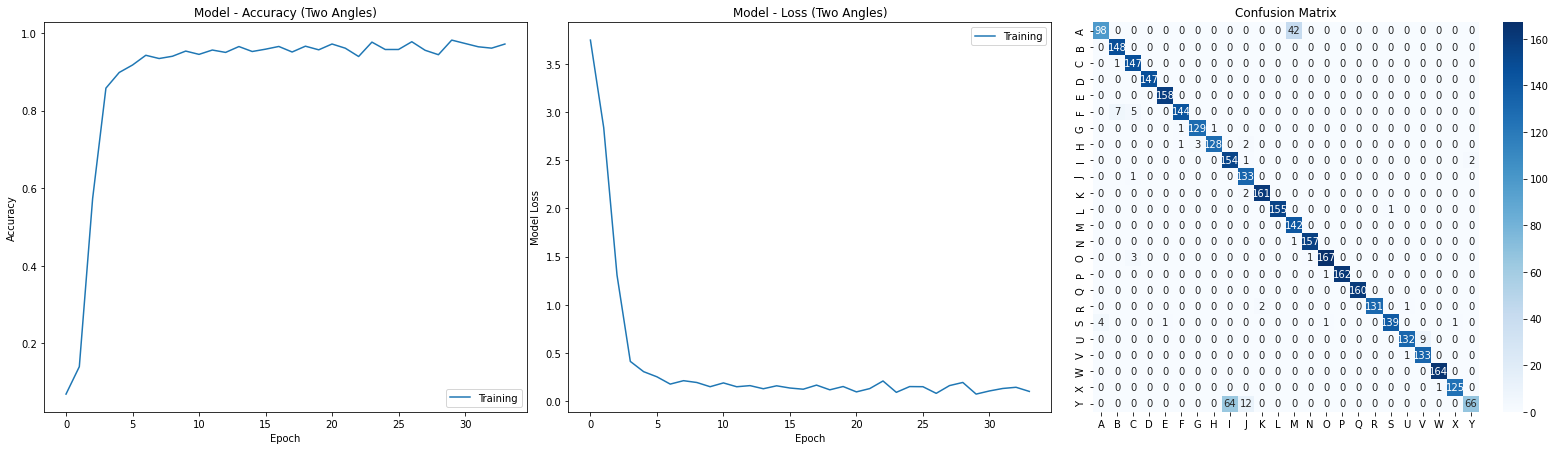


Accuracy: 95.13% 

              precision    recall  f1-score   support

           A       0.96      0.70      0.81       140
           B       0.95      1.00      0.97       148
           C       0.94      0.99      0.97       148
           D       1.00      1.00      1.00       147
           E       0.99      1.00      1.00       158
           F       0.99      0.92      0.95       156
           G       0.98      0.98      0.98       131
           H       0.99      0.96      0.97       134
           I       0.71      0.98      0.82       157
           J       0.89      0.99      0.94       134
           K       0.99      0.99      0.99       163
           L       1.00      0.99      1.00       156
           M       0.77      1.00      0.87       142
           N       0.99      0.99      0.99       158
           O       0.99      0.98      0.98       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [33]:
two_angles_results = evaluate_model(history, X_test, y_test, model_two_angles, "Two Angles", actions)

In [38]:
list_of_metrics['two_angles'] = two_angles_results

In [39]:
with open('data/results_new.pkl','wb') as f:
    pickle.dump(list_of_metrics, f)

### **iii) Distance + Angles**

In [41]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    
                    
                    distance_1 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                                (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y) )
                    
                    distance_2 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                                (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y) )

                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                        # landmarks.append(lmx)
                        # landmarks.append(lmy)
                    landmarks.append([angle_1, angle_2])
                    landmarks.append([distance_1, distance_2])
                    # landmarks.append(angle_1)
                    # landmarks.append(angle_2)
                    # landmarks.append(distance_1)
                    # landmarks.append(distance_2)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [42]:
print(data.shape, labels.shape)

(17764, 23, 2) (17764,)


In [44]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 23, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 23, 2) (14211, 24) 

Test:
 (3553, 23, 2) (3553, 24) 



In [45]:
model_angle_and_distance, history = train_model( (X_train.shape[1], X_train.shape[2]), y_train.shape[1])
# model_angle_and_distance, history = train_model( (X_train.shape[1], 0), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 3ms/step - loss: 2.1948 - accuracy: 0.4665
Epoch 2/50
445/445 [==============================] - 1s 3ms/step - loss: 0.3891 - accuracy: 0.8703
Epoch 3/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2098 - accuracy: 0.9366
Epoch 4/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2072 - accuracy: 0.9374
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1930 - accuracy: 0.9395
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2310 - accuracy: 0.9285
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1484 - accuracy: 0.9570
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1271 - accuracy: 0.9628
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1685 - accuracy: 0.9515
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.9535

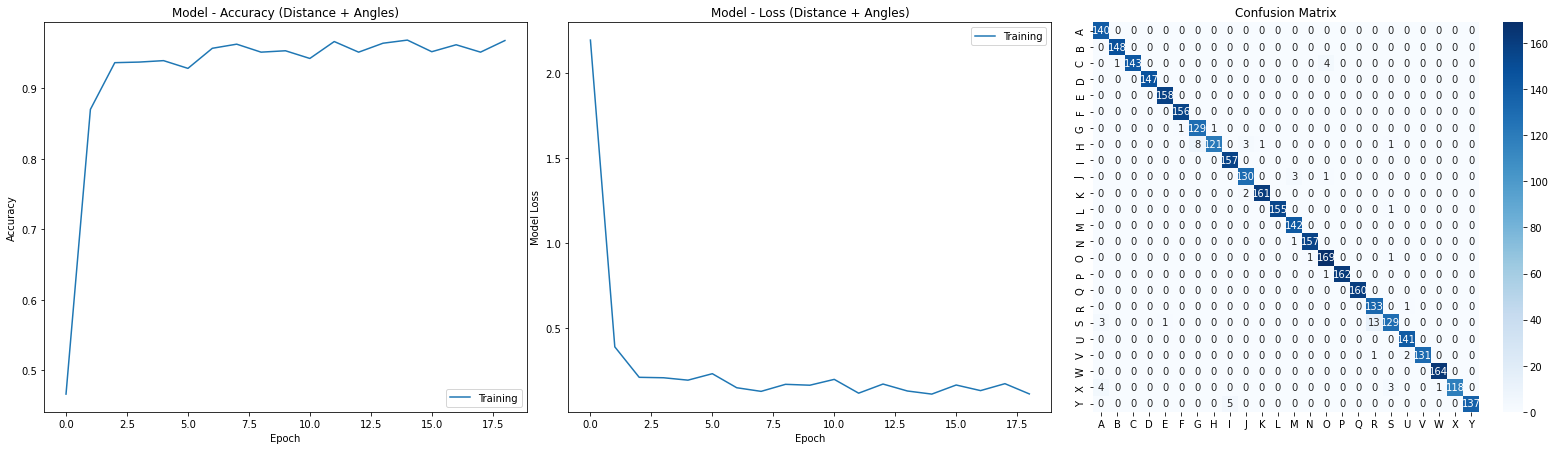


Accuracy: 98.17% 

              precision    recall  f1-score   support

           A       0.95      1.00      0.98       140
           B       0.99      1.00      1.00       148
           C       1.00      0.97      0.98       148
           D       1.00      1.00      1.00       147
           E       0.99      1.00      1.00       158
           F       0.99      1.00      1.00       156
           G       0.94      0.98      0.96       131
           H       0.99      0.90      0.95       134
           I       0.97      1.00      0.98       157
           J       0.96      0.97      0.97       134
           K       0.99      0.99      0.99       163
           L       1.00      0.99      1.00       156
           M       0.97      1.00      0.99       142
           N       0.99      0.99      0.99       158
           O       0.97      0.99      0.98       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [46]:
angle_and_distance_results = evaluate_model(history, X_test, y_test, model_angle_and_distance, "Distance + Angles", actions)

In [47]:
# with open('data/results.pkl', 'rb') as f:
#     list_of_metrics = pickle.load(f)

list_of_metrics['angle+distance'] = angle_and_distance_results

with open('data/results_new.pkl', 'wb') as f:
     pickle.dump(list_of_metrics, f)

In [56]:
list_of_metrics['angle+distance']

{'metrics': {'A': {'precision': 0.9523809523809523,
   'recall': 1.0,
   'f1-score': 0.975609756097561,
   'support': 140},
  'B': {'precision': 0.9932885906040269,
   'recall': 1.0,
   'f1-score': 0.9966329966329966,
   'support': 148},
  'C': {'precision': 1.0,
   'recall': 0.9662162162162162,
   'f1-score': 0.9828178694158076,
   'support': 148},
  'D': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 147},
  'E': {'precision': 0.9937106918238994,
   'recall': 1.0,
   'f1-score': 0.9968454258675079,
   'support': 158},
  'F': {'precision': 0.9936305732484076,
   'recall': 1.0,
   'f1-score': 0.9968051118210862,
   'support': 156},
  'G': {'precision': 0.9416058394160584,
   'recall': 0.9847328244274809,
   'f1-score': 0.9626865671641791,
   'support': 131},
  'H': {'precision': 0.9918032786885246,
   'recall': 0.9029850746268657,
   'f1-score': 0.9453125,
   'support': 134},
  'I': {'precision': 0.9691358024691358,
   'recall': 1.0,
   'f1-score': 0.9843260188087775,
  

## **B. Random Forest**

In [48]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    # angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                         (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                    #                         (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    # angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                    #                     (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                    #                     (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    
                    
                    # distance_1 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                             (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y) )
                    
                    # distance_2 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                             (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y) )

                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append(lmx) 
                        landmarks.append(lmy)
                    # landmarks.append([angle_1, angle_2])
                    # landmarks.append([distance_1, distance_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [49]:
print(data.shape, labels.shape)

(17764, 42) (17764,)


In [51]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 42) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 42) (14211, 24) 

Test:
 (3553, 42) (3553, 24) 



In [52]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train) 

RandomForestClassifier(random_state=42)

In [53]:
y_pred = clf.predict(X_test)

Accuracy:  0.993 %


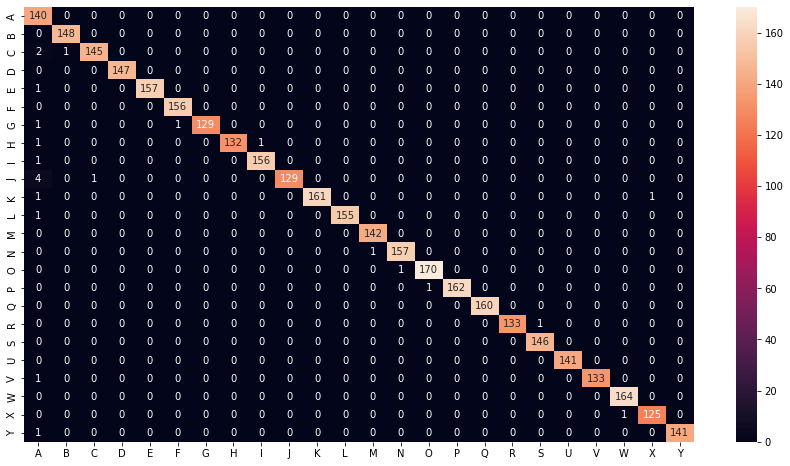

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       140
           1       0.99      1.00      1.00       148
           2       0.99      0.98      0.99       148
           3       1.00      1.00      1.00       147
           4       1.00      0.99      1.00       158
           5       0.99      1.00      1.00       156
           6       1.00      0.98      0.99       131
           7       1.00      0.99      0.99       134
           8       0.99      0.99      0.99       157
           9       1.00      0.96      0.98       134
          10       1.00      0.99      0.99       163
          11       1.00      0.99      1.00       156
          12       0.99      1.00      1.00       142
          13       0.99      0.99      0.99       158
          14       0.99      0.99      0.99       171
          15       1.00      0.99      1.00       163
          16       1.00      1.00      1.00       160
          17       1.00    

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy: ", round(accuracy_score(y_test, y_pred),3), "%")

plt.figure(figsize=(15,8))
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax= sns.heatmap(cnf_matrix, annot=True,  fmt='g',
                  xticklabels=actions, yticklabels=actions)
plt.show()

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [58]:
list_of_metrics['Random_forest'] = {"metrics": classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=actions, output_dict=True)}

with open('data/results_new.pkl', 'wb') as f:
     pickle.dump(list_of_metrics, f)

## **C. XGBoost**

In [ ]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    # angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                         (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                    #                         (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    # angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                    #                     (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                    #                     (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    
                    
                    # distance_1 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                             (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y) )
                    
                    # distance_2 = get_distance( (handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                    #                             (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y) )

                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append(lmx) 
                        landmarks.append(lmy)
                    # landmarks.append([angle_1, angle_2])
                    # landmarks.append([distance_1, distance_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [ ]:
print(data.shape, labels.shape)

In [ ]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

In [ ]:
import xgboost as xgb



<br>

---

<br>

## **Results**

In [59]:
print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [61]:
with open('data/results_new.pkl', 'rb') as f:
    list_of_metrics = pickle.load(f)

for key in list_of_metrics.keys():
    print(key)

only_coordinates
two_angles
angle+distance
Random_forest


In [62]:
results = {}

for method in list_of_metrics.keys():

    alpha_results = {}
    metrics = list_of_metrics[method]['metrics']
    
    for key,value in metrics.items():
        if key in actions:
            alpha_results[key] = {'precision':round(value['precision'], 3), 'f1':round(value['f1-score'], 3), 'recall':round(value['recall'], 3)} 
        
        elif key=='accuracy':
            accuracy = value
        elif key=='weighted avg':
            results[method] = {"Accuracy": accuracy, "F1": round(value['f1-score'],3), "Sub-Scores": alpha_results}

for (key, value) in results.items(): 
    print(key, ":\n", "Accuracy: ", value["Accuracy"], "\n F1: ", value["F1"], "\n Sub-Scores: ")
    for k,v in value["Sub-Scores"].items():
            print("\t", k, ": ", v)
    print("\n\n")

only_coordinates :
 Accuracy:  0.8615254714325922 
 F1:  0.855 
 Sub-Scores: 
	 A :  {'precision': 0.959, 'f1': 0.979, 'recall': 1.0}
	 B :  {'precision': 0.987, 'f1': 0.993, 'recall': 1.0}
	 C :  {'precision': 0.836, 'f1': 0.882, 'recall': 0.932}
	 D :  {'precision': 1.0, 'f1': 0.67, 'recall': 0.503}
	 E :  {'precision': 0.977, 'f1': 0.893, 'recall': 0.823}
	 F :  {'precision': 0.994, 'f1': 0.997, 'recall': 1.0}
	 G :  {'precision': 0.86, 'f1': 0.918, 'recall': 0.985}
	 H :  {'precision': 0.942, 'f1': 0.89, 'recall': 0.843}
	 I :  {'precision': 0.714, 'f1': 0.772, 'recall': 0.841}
	 J :  {'precision': 0.981, 'f1': 0.867, 'recall': 0.776}
	 K :  {'precision': 1.0, 'f1': 0.984, 'recall': 0.969}
	 L :  {'precision': 0.803, 'f1': 0.888, 'recall': 0.994}
	 M :  {'precision': 0.791, 'f1': 0.878, 'recall': 0.986}
	 N :  {'precision': 0.994, 'f1': 0.994, 'recall': 0.994}
	 O :  {'precision': 0.889, 'f1': 0.427, 'recall': 0.281}
	 P :  {'precision': 1.0, 'f1': 0.997, 'recall': 0.994}
	 Q :  {'